In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.contrib.layers import fully_connected

np.random.seed(333)
tf.set_random_seed(333)

/home/am/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load MNIST data in a format suited for tensorflow.
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples
n_input = mnist.train.images[0].shape[0]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
class VariationalAutoencoder(object):
    def __init__(self,n_input, n_z,
                 learning_rate=0.001, batch_size=100):
        self.batch_size = batch_size
        self.n_input = n_input
        self.n_z = n_z
        
        # Place holder for the input 
        self.x = tf.placeholder(tf.float32, shape = [None, n_input])
        
        
        # Use Encoder Network to determine mean and 
        # (log) variance of Gaussian distribution in the latent space
        self.z_mean, self.z_log_sigma_sq = self._encoder_network()

        # Draw a sample z from Gaussian distribution
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean,tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use Decoder network to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_hat = self._decoder_network()
            
            
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        # define generation loss
        reconstruction_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_hat)
                + (1-self.x) * tf.log(1e-10 + 1 - self.x_hat), 1)
        self.reconstruction_loss = tf.reduce_mean(reconstruction_loss)
        
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                    - tf.square(self.z_mean)- tf.exp(self.z_log_sigma_sq), 1)
        self.latent_loss = tf.reduce_mean(latent_loss)
        self.cost = tf.reduce_mean(reconstruction_loss + latent_loss)   # average over batch
        # Define the optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
           
            
    # Create encoder network
    def _encoder_network(self):
        # Generate probabilistic encoder (inference network), which
        # maps inputs onto a normal distribution in latent space.
        layer_1 = fully_connected(self.x,500,activation_fn=tf.nn.softplus) 
        layer_2 = fully_connected(layer_1, 500, activation_fn=tf.nn.softplus) 
        z_mean = fully_connected(layer_2,self.n_z, activation_fn=None)
        z_log_sigma_sq = fully_connected(layer_2, self.n_z, activation_fn=None)
        return (z_mean, z_log_sigma_sq)

    # Create decoder network
    def _decoder_network(self):
        # Generate probabilistic decoder (generator network), which
        # maps points in the latent space onto a Bernoulli distribution in the data space.
        layer_1 = fully_connected(self.z,500,activation_fn=tf.nn.softplus) 
        layer_2 = fully_connected(layer_1, 500, activation_fn=tf.nn.softplus)  
        x_hat = fully_connected(layer_2, self.n_input, activation_fn=tf.nn.sigmoid)
            
        return x_hat
            
       
        
    def single_step_train(self, X):
        _,cost,recon_loss,latent_loss = self.sess.run([self.optimizer, self.cost,self.reconstruction_loss,self.latent_loss], 
                                  feed_dict={self.x: X})
        return cost, recon_loss, latent_loss
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=n_z)
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_hat, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_hat, 
                             feed_dict={self.x: X})

In [4]:
def train(n_input,n_z, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(n_input,n_z, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        avg_r_loss = 0.
        avg_l_loss = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost,r_loss, l_loss = vae.single_step_train(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size
            avg_r_loss += r_loss / n_samples * batch_size
            avg_l_loss += l_loss / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:  {:4d} cost={:.4f}  Reconstruction loss = {:.4f}  Latent Loss = {:.4f}".
                  format(epoch,avg_cost,avg_r_loss,avg_l_loss))
    return vae

In [5]:
n_z=10  # dimensionality of latent space

vae = train(n_input,n_z,training_epochs=100)

Epoch:     0 cost=177.7624  Reconstruction loss = 171.4143  Latent Loss = 6.3481
Epoch:     5 cost=110.7841  Reconstruction loss = 94.2649  Latent Loss = 16.5192
Epoch:    10 cost=104.7110  Reconstruction loss = 86.5796  Latent Loss = 18.1314
Epoch:    15 cost=102.3811  Reconstruction loss = 83.8277  Latent Loss = 18.5535
Epoch:    20 cost=101.0192  Reconstruction loss = 82.2603  Latent Loss = 18.7589
Epoch:    25 cost=99.9811  Reconstruction loss = 81.0854  Latent Loss = 18.8957
Epoch:    30 cost=99.1842  Reconstruction loss = 80.1694  Latent Loss = 19.0148
Epoch:    35 cost=98.5227  Reconstruction loss = 79.4611  Latent Loss = 19.0616
Epoch:    40 cost=97.9145  Reconstruction loss = 78.8046  Latent Loss = 19.1099
Epoch:    45 cost=97.4815  Reconstruction loss = 78.3192  Latent Loss = 19.1623
Epoch:    50 cost=97.0883  Reconstruction loss = 77.8916  Latent Loss = 19.1967
Epoch:    55 cost=96.6536  Reconstruction loss = 77.4327  Latent Loss = 19.2209
Epoch:    60 cost=96.3638  Reconstr

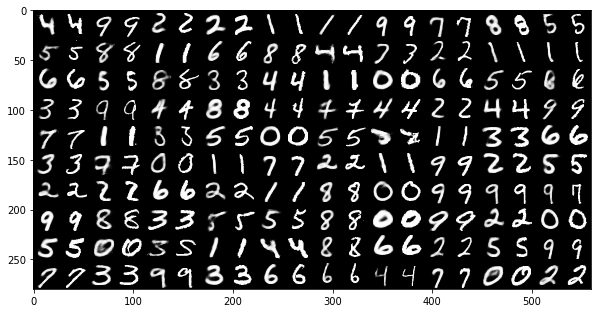

In [6]:
# Test the trained model: reconstruction
w = h = 28
batch = mnist.test.next_batch(100)
x_reconstructed = vae.reconstruct(batch[0])

n = np.sqrt(vae.batch_size).astype(np.int32)
I_reconstructed = np.empty((h*n, 2*w*n))
for i in range(n):
    for j in range(n):
        x = np.concatenate(
            (x_reconstructed[i*n+j, :].reshape(h, w), 
             batch[0][i*n+j, :].reshape(h, w)),
            axis=1
        )
        I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

plt.figure(figsize=(10, 20))
plt.imshow(I_reconstructed, cmap='gray')

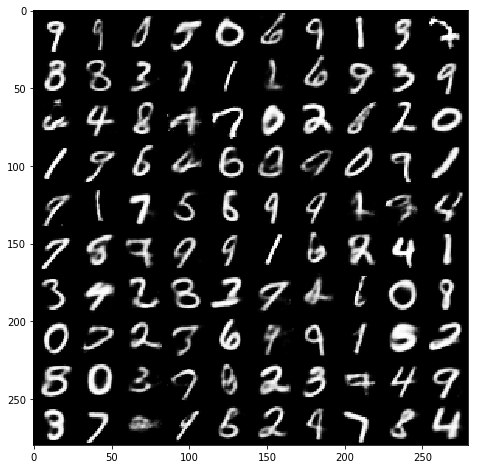

In [7]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[vae.batch_size, vae.n_z])
x_generated = vae.generate(z)

n = np.sqrt(vae.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(28, 28)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')

In [8]:
n_z=2  # dimensionality of latent space
tf.reset_default_graph()
vae_2d = train(n_input,n_z,training_epochs=100)

Epoch:     0 cost=190.4920  Reconstruction loss = 187.3914  Latent Loss = 3.1006
Epoch:     5 cost=153.7174  Reconstruction loss = 148.1031  Latent Loss = 5.6143
Epoch:    10 cost=148.1305  Reconstruction loss = 142.1184  Latent Loss = 6.0121
Epoch:    15 cost=145.5968  Reconstruction loss = 139.3989  Latent Loss = 6.1979
Epoch:    20 cost=144.0174  Reconstruction loss = 137.7337  Latent Loss = 6.2837
Epoch:    25 cost=142.8392  Reconstruction loss = 136.4487  Latent Loss = 6.3905
Epoch:    30 cost=142.0323  Reconstruction loss = 135.5803  Latent Loss = 6.4520
Epoch:    35 cost=141.3513  Reconstruction loss = 134.8311  Latent Loss = 6.5201
Epoch:    40 cost=140.7743  Reconstruction loss = 134.2062  Latent Loss = 6.5681
Epoch:    45 cost=140.2939  Reconstruction loss = 133.6786  Latent Loss = 6.6153
Epoch:    50 cost=139.8537  Reconstruction loss = 133.2091  Latent Loss = 6.6446
Epoch:    55 cost=139.5072  Reconstruction loss = 132.8231  Latent Loss = 6.6841
Epoch:    60 cost=139.1816  

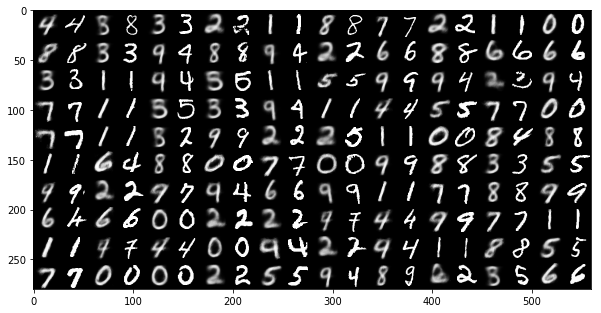

In [9]:
# Test the trained model: reconstruction
w = h = 28
batch = mnist.test.next_batch(100)
x_reconstructed = vae_2d.reconstruct(batch[0])

n = np.sqrt(vae_2d.batch_size).astype(np.int32)
I_reconstructed = np.empty((h*n, 2*w*n))
for i in range(n):
    for j in range(n):
        x = np.concatenate(
            (x_reconstructed[i*n+j, :].reshape(h, w), 
             batch[0][i*n+j, :].reshape(h, w)),
            axis=1
        )
        I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

plt.figure(figsize=(10, 20))
plt.imshow(I_reconstructed, cmap='gray')

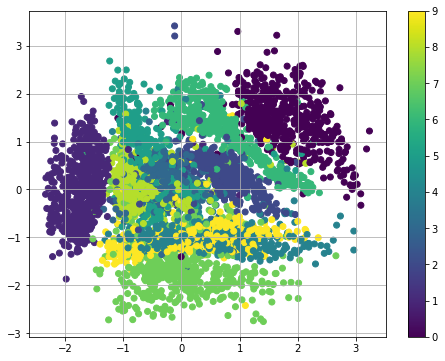

In [10]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

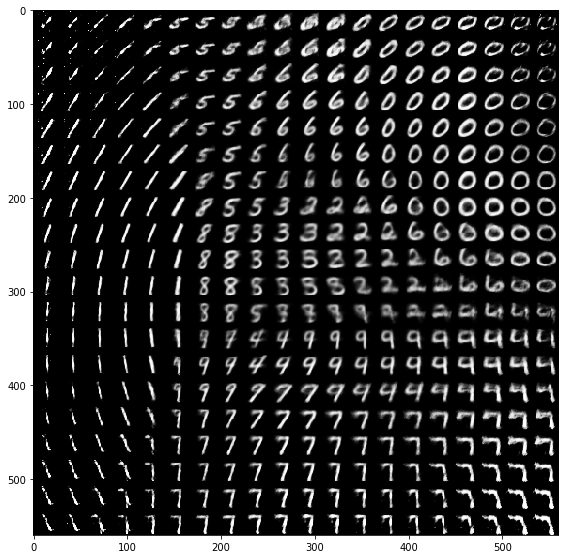

In [11]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae_2d.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()